In [1]:
!pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/

In [4]:
import torch
import torchvision

from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt

# Initial Embeddings

This allows us to break an image into 2D patches of size (P, P)

In [ ]:
# Remember that in pytorch we deal with images of dimension (N, C, H, W)
class EmbeddedPatches(nn.Module):
  def __init__(self, input_channels=3, patch_dim=16, output_dim=768):
    super().__init__()

    self.layer = nn.Conv2d(in_channels=input_channels, out_channels=output_dim, kernel_size=patch_dim, stride=patch_dim)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    # Ensuring that the image can be evenly divided into the patch size
    assert x[-1] % patch_dim == 0

    x = self.flatten(self.layer(x))

    # Going from (batch, C*P^2, N) to (batch, N, C*P^2) where N = HW/P^2 or number of patches
    return x.permute(0, 2, 1)

Adding a class embedding and position embedding to the patch embeddings

In [ ]:
# Temp Variables for Checking to See if Everything Works
batch_size = 8
height = 256
width = 256
patch_size = 16
embedding_dimension = 768
num_of_patches = height * width // (patch_size ** 2)

In [ ]:
class_embedding = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad=True)
position_embedding = nn.Parameter(torch.randn(1, num_of_patches + 1, embedding_dimension))

We then concatenate those embeddings to the patch embeddings, together this gives us

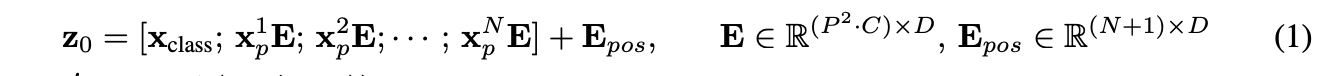

# Transformer Encoder Section

In [5]:
class MSABlock(nn.Module):
  def __init__(self, embedding_dim, num_heads, dropout):
    super().__init__()

    self.norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.msa = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout, batch_first=True)

  def forward(self, x):
    x = self.norm(x)

    attention, _ = self.msa(query=x, key=x, value=x, need_weights=False)

    return attention

In [6]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim, num_neurons, dropout):
    super().__init__()

    self.norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=num_neurons),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(in_features=num_neurons, out_features=embedding_dim),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    return self.mlp(self.norm(x))

Together these two help to contribute to the following equations:

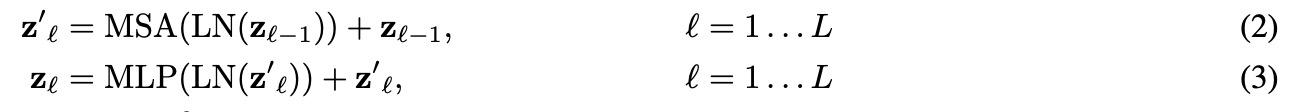

# Combining into Transformer Encoder Block

In [7]:
class TransformerEncoder(nn.Module):
  def __init__(self, embedding_dim, num_heads, num_neurons, dropout):
    super().__init__()

    self.msa_block = MSABlock(embedding_dim=embedding_dim, num_heads=num_heads, dropout=dropout)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim, num_neurons=num_neurons, dropout=dropout)

  def forward(self, x):
    x_msa = self.msa_block(x) + x
    x_mlp = self.mlp_block(x_msa) + x_msa

    return x_mlp

# Putting Everything Together into a Vision Transformer Class

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, img_width, input_channels, num_transformer_layers, embed_dim, patch_width, mlp_neurons,
               num_heads, attention_dropout, mlp_dropout, embed_dropout, classes):
    super().__init__()

    # First make sure the patch can evenly divide the image
    assert img_width % patch_width == 0

    self.num_of_patches = (img_width ** 2) // (patch_width ** 2)

    # Get the class and position embeddings like we did above
    self.class_embed = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
    self.pos_emebd = nn.Parameter(torch.randn(1, self.num_of_patches + 1, embed_dim), requires_grad=True)

    # Create a PatchEmbedding Block
    self.patch_embed = EmbeddedPatches(input_channels=input_channels, patch_dim=patch_width, output_dim=embed_dim)

    self.embed_dropout = nn.Dropout(p=embed_dropout)

    # Transformer Encoder Blocks that we will stack
    self.transformer_encoder_block = nn.Sequential(
        *[TransformerEncoder(embedding_dim=embed_dim, num_heads=num_heads, num_neurons=mlp_neurons, dropout=mlp_dropout) for _ in range(num_transformer_layers)]
    )

    self.class_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embed_dim),
        nn.Linear(in_features=embed_dim, out_features=classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]

    # Get the embeddings
    x = self.patch_embed(x)
    x = torch.cat((self.class_embed.expand(batch_size, -1, -1), x), dim=1)
    x = self.pos_embed + x
    x = self.embed_dropout(x)

    # Apply the Transformer Encoder
    x = self.transformer_encoder_block(x)

    # Finally, apply classifier head
    # Note, we use index 0 here because of equation 4 in the paper
    x = self.classifier(x[:, 0])

    return x


# Testing